# Simple Classification Model

In [1]:
import pandas as pd
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88, got 80


## Import data

In [2]:
movies = pd.read_csv('./data/movies_cleaned.csv')

In [3]:
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Genre,Plot,plot_length
0,1903,The Great Train Robbery,American,Edwin S. Porter,western,The film opens with two bandits breaking into ...,239
1,1904,The Suburbanite,American,Wallace McCutcheon,comedy,The film is about a family who move to the sub...,34
2,1907,How Brown Saw the Baseball Game,American,Unknown,comedy,Before heading out to a baseball game at a nea...,103
3,1907,Laughing Gas,American,Edwin Stanton Porter,comedy,The plot is that of a black woman going to the...,48
4,1908,The Adventures of Dollie,American,D. W. Griffith,drama,On a beautiful summer day a father and mother ...,143


In [8]:
# gonna start with a simple binary classification task using the two most common genres
data = movies[movies['Genre'].isin(['comedy', 'drama'])].copy(deep=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10343 entries, 1 to 20956
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      10343 non-null  int64 
 1   Title             10343 non-null  object
 2   Origin/Ethnicity  10343 non-null  object
 3   Director          10343 non-null  object
 4   Genre             10343 non-null  object
 5   Plot              10343 non-null  object
 6   plot_length       10343 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 646.4+ KB


## Baseline

In [10]:
data['Genre'].value_counts(normalize=True)

drama     0.576622
comedy    0.423378
Name: Genre, dtype: float64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data['Plot'], data['Genre'])

## Make some models

### Basic Log Model

In [26]:
cvect = CountVectorizer()

In [13]:
X_train_vect = cvect.fit_transform(X_train)
X_test_vect = cvect.transform(X_test)

In [18]:
logr = LogisticRegression(max_iter=1000)

In [19]:
logr.fit(X_train_vect, y_train)

LogisticRegression(max_iter=1000)

In [20]:
logr.score(X_test_vect, y_test)

0.7459396751740139

Better than the null model but let's see if we can improve on this

#### Adding standard scaler

In [21]:
scaler = StandardScaler(with_mean=False)

In [22]:
X_train_scaled = scaler.fit_transform(X_train_vect)
X_test_scaled = scaler.transform(X_test_vect)

In [23]:
logr.fit(X_train_scaled, y_train)
logr.score(X_train_scaled, y_train)

0.9998710841820291

In [24]:
logr.score(X_test_scaled, y_test)

0.7219644238205724

### Log model with Tfidf

In [27]:
tfidf = TfidfVectorizer()

In [28]:
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [29]:
logr.fit(X_train_tf, y_train)
logr.score(X_train_tf, y_train)

0.9036998839757638

In [30]:
logr.score(X_test_tf, y_test)

0.7614075792730085

Best model yet. Let's optimize it

## Grid Search/Pipeline time

In [35]:
X_train.shape

(7757,)

In [31]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression())

In [36]:
params = {
    'tfidfvectorizer__stop_words': ['english', None],
    'tfidfvectorizer__max_features': [1000, 2500, 5000, 7500, None],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
    'logisticregression__C': [0.01, 0.1, 1, 10, 100]
}

In [37]:
gs = GridSearchCV(pipe, params, n_jobs = -1)

In [38]:
%%time
gs.fit(X_train, y_train)

CPU times: user 24 s, sys: 15 s, total: 39 s
Wall time: 44min 33s


/Users/juliana/miniforge3/envs/tensorflow/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100],
                         'tfidfvectorizer__max_features': [1000, 2500, 5000,
                                                           7500, None],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3), (2, 2),
                                                          (2, 3), (3, 3)],
                         'tfidfvectorizer__stop_words': ['english', None]})

In [39]:
gs.best_estimator_

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('logisticregression', LogisticRegression(C=100))])

In [42]:
gs.best_params_

{'logisticregression__C': 100,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__stop_words': None}

In [40]:
gs.score(X_test, y_test)

0.7815158546017015

In [43]:
pipe2 = make_pipeline(TfidfVectorizer(ngram_range = (1, 2)), LogisticRegression(C=100, max_iter=1000))

In [44]:
pipe2.fit(X_train, y_train)
pipe2.score(X_train, y_train)

0.9998710841820291

In [45]:
pipe2.score(X_test, y_test)

0.7819025522041764

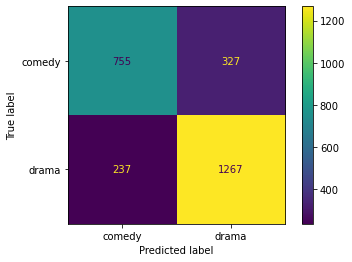

In [46]:
plot_confusion_matrix(pipe2, X_test, y_test)

## Trying some lemmatization

In [48]:
nlp = spacy.load('en_core_web_sm')

In [49]:
def lemmatizer(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

In [51]:
pipe3 = make_pipeline(TfidfVectorizer(ngram_range = (1, 2), tokenizer=lemmatizer), LogisticRegression(C=100, max_iter=1000))

In [52]:
%%time
pipe3.fit(X_train, y_train)

CPU times: user 17min 7s, sys: 14.2 s, total: 17min 21s
Wall time: 17min 46s


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function lemmatizer at 0x2b1da0d30>)),
                ('logisticregression',
                 LogisticRegression(C=100, max_iter=1000))])

In [53]:
%%time
pipe3.score(X_test, y_test)

CPU times: user 5min 47s, sys: 4.46 s, total: 5min 52s
Wall time: 6min 1s


0.7877030162412993